In [2]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


# Load the train data
cambia e fai load su cartella 2020


In [6]:
train_data = pd.read_csv('/home/gdeandrea/Scrivania/UNI/Data Mining/DataCulo/INT0911_2019/Kaggle data/datamining2019/train_data.csv.gz', compression="gzip", encoding="utf8")

In [7]:
train_data.head()
#shape(train_data)

,author,subreddit,created_utc,body
0,Shamus_Aran,mylittlepony,1.388534e+09,I don't think we'd get nearly as much fanficti...
1,Riddance,sex,1.388534e+09,"Thanks. I made it up, that's how I got over my..."
2,Secret_Wizard,DragonsDogma,1.388534e+09,Are you sure you aren't confusing Cyclops (the...
3,Penultimatum,malefashionadvice,1.388534e+09,dont do this to me bro
4,7-SE7EN-7,todayilearned,1.388534e+09,That's what we do when we can't find a mate


In [8]:
train_data.author.unique().shape
train_data.subreddit.unique().shape


(3468,)

di nuovo come sopra

In [9]:
target = pd.read_csv('/home/gdeandrea/Scrivania/UNI/Data Mining/DataCulo/INT0911_2019/Kaggle data/datamining2019/train_target.csv')

In [10]:
target.head()

,author,gender
0,RedThunder90,0
1,Lirkmor,1
2,In0chi,0
3,ProjectGrudge,0
4,TehTurtleHermit,0


# Feature Extraction

**Subreddits exctraction**

In [11]:
subreddits = train_data.subreddit.unique() # vett. dei subreddits:
                                           # prende da subreddit di train_data contandoli una sola volta {unique()}
subreddits_map = pd.Series(index=subreddits, data=arange(subreddits.shape[0])) #pd.Series: indicizza i subreddit.
                                           # vett. (nomesubreddit, etichetta)

In [12]:
from scipy import sparse

In [13]:
def extract_features(group):                        # prende l'autore
    
    group_subreddits = group['subreddit'].values    # vett. dei nomi dei subreddit 
                                                    
    idxs = subreddits_map[group_subreddits].values  # vettore etichette subreddit
    
    v = sparse.dok_matrix((1, subreddits.shape[0])) # matrice sparsa 1xN°subreddit diversi
    
    for idx in idxs:
        if not np.isnan(idx):   #per ogni etichetta non nulla assegno 1 nella matrice sparsa
                                #per ogni autore assegno a Vij il valore 1 se l'autore ha partecipato al subreddit
                                
            v[0, idx] = 1
            
    return v.tocsr()            #converto v in formato csr

#es: creo v: vettore riga sparso che indica in quali subreddit RedThunder90 ha partecipato
extract_features(train_data[train_data.author=='RedThunder90'])

<1x3468 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>

In [14]:
features_dict = {}     #creo dizionario delle features
                       #associa a ogni autore il suo vettore riga v che indica i subreddits in cui ha partecipato

for author, group in train_data.groupby('author'):  
    features_dict[author] = extract_features(group)

In [15]:
X = sparse.vstack([features_dict[author] for author in target.author])

In [16]:
y = target.gender

# Text extraction

In [17]:
def extract_text(group):
    group_text = group['body'].values
    return " ".join(group_text)

#extract_text(train_data[train_data.author=='RedThunder90'])
extract_text(train_data[train_data.subreddit=='sex'])

'Thanks. I made it up, that\'s how I got over my first heart break.  They almost certainly weren\'t consciously faking it, for those few years, they probably were "changed" and putting honest effort in to be more what their partner wanted. But, you can only fight your true nature so much and for so long, so eventually they return to their actual selves.  It\'s why it\'s so important to be honest in a relationship and to yourself.  It\'s much better to find out you\'re not compatible and be free to find someone with whom you are than it is to think you can "suck it up" or "compromise" or "settle" and have a life where neither of you are happy and you grow to resent your partner over what should have been. You\'ve hit all the points.  She sounds like my ex wife.  No bueno. When I had libidio issues, I cared about it. I cared that my husband felt rejected or not good enough for me and I missed being able to enjoy being close and intimate with him. I did everything I could to be close to h

In [18]:
# creo dizionario con 'keys'=author e valori = a quello che ha scritto l'autore

text_dict = {}

for author, group in train_data.groupby('author'):
    text_dict[author] = extract_text(group)
    

In [19]:
# creo array di stringhe dove ogni riga corrisponde a quello che ha scritto un diverso autore nei diversi topic

author_text = [text_dict[author] for author in target.author]
author_text[4]

"Darn, someone already used it.  Yep, a co-worker showed me this. As soon as I have the money, I'm canceling my account with Sprint. Drinking tea with local honey will help, somewhat. Bees pollinating  everything, those dirty little bees. As someone who has done support for a TON of video game companies:\n**NO.** For kids! I really hate to say, but check out a school system called Harmony Science Academy. I went there from 6th to 12th. One of the requirements of graduation is to get accepted to a 4 year college. They've never had one person not graduate because of it. The teachers all really do care. They are very good with academics, but not so much sports. If you really are looking for a good college prep school, I couldn't recommend a better one. I had an ex give me this. \nEX. Famine, disease, introduction to Native Americans?  Oh gosh, The Return of the King! It is so much fun to play with friends! Ironically, I have that same thing on my desk. Who would have thought?"

In [22]:
# estraggo il testo e lo converto in una matrice sparsa Xij 
# con i autore e j "feature" ovvero le parole usate nel suo testo che non fanno parte della lista stop_words.
# N.B: posso usare come feature anche coppie di parole consecutive cambiando in ngram_range(1,2)
# o entrambe (sia singole che coppie) usando ngram_range(0,2)

from sklearn.feature_extraction import text


stop_words = set(list(text.ENGLISH_STOP_WORDS))

cv = text.CountVectorizer(max_df = 0.95, min_df = 0.01, stop_words = stop_words)
C = cv.fit_transform(author_text)

tfidf = text.TfidfTransformer().fit_transform(C)

In [23]:
#verifico n°di righe perchè possa aggiungerla a X e n° di colonne per possibili "Memory errors"
#N.B: calcolo il peso della matrice da allocare in RAM come [n°righe x n°colonne x 64/32 (64-> float, 32->int)
print('SHAPE&TYPE TFIDF:', shape(tfidf),' || ', type(tfidf))
print('SHAPE&TYPE X:', shape(X),' || ', type(X))

SHAPE&TYPE TFIDF: (5000, 7276)  ||  <class 'scipy.sparse.csr.csr_matrix'>
SHAPE&TYPE X: (5000, 3468)  ||  <class 'scipy.sparse.csr.csr_matrix'>


In [18]:
#attacco X a tfidf per la mia nuova Input Matrix X1

#from scipy.sparse import hstack

Xarray=X.toarray()
tfidfarray=tfidf.toarray()


X3 = hstack((Xarray,tfidfarray)) #nel caso voglia tutte le features

X1 = Xarray #nel caso voglia solo i subreddits

X2 = tfidfarray #matrice dati tfidf


print(type(X3),' |ALL FEATURES| ',shape(X3))
print(type(X1),' | SUBREDDITS | ',shape(X1))
print(type(X2),' |   TFIDF    | ',shape(X2))


<class 'numpy.ndarray'>  |ALL FEATURES|  (5000, 10744)
<class 'numpy.ndarray'>  | SUBREDDITS |  (5000, 3468)
<class 'numpy.ndarray'>  |   TFIDF    |  (5000, 7276)


**Mantengo divisi i dataset di subreddit e testo per vedere se posso applicare modelli diversi che si adattano meglio a ltipo di dati**

# Features Selection - SUBREDDITS

from sklearn.decomposition import PCA 
pca = PCA()

pca.fit(X1)

U = pca.transform(X1)
S = pca.explained_variance_ 
V = pca.components_

print (U.shape)
print (S.shape)
print (V.shape)

ev_cumsum = np.cumsum(pca.explained_variance_)/(pca.explained_variance_).sum() 

ev_at90 = ev_cumsum[ev_cumsum<0.9].shape[0]
print (ev_at90)

plt.plot(ev_cumsum)
plt.vlines(ev_at90, 0, 1, linestyles='dashed')
plt.hlines(0.9, 500, 2000, linestyles='dashed');


**STOP** guarda le features!!

Trovo {{ev_at90}} features "importanti"

pca = PCA(ev_at90)
pca.fit(X1)
U = pca.transform(X1)
print (U.shape)

In [19]:
from sklearn.model_selection import StratifiedKFold, train_test_split

#nfold = StratifiedKFold(n_splits=5)
# Takes group information into account to avoid 
# building folds with imbalanced class distributions 
#(for binary or multiclass classification tasks).

X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=.2, random_state = 32)


# Model Selection - SUBREDDITS

In [20]:
# importo cose utili
from sklearn.model_selection import cross_val_score, GridSearchCV

#importo i modelli
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from collections import OrderedDict

# creo dizionario dei modelli di classificazione
# Multinomial Naive Bayes non funziona perchè dopo la PCA i dati possono assumere valori negativi (in X hanno valore 0 o 1 a seconda che l'autore abbia o no partecipato al subreddit)
#PERCHé assumono vaori anche negativi? perchè sono nuove features combo lineari degli 0 e 1?
models = OrderedDict([
          ('Knn 5', KNeighborsClassifier(4)),
          ('Gaussian Naive Bayes', GaussianNB()),
          ('Multinomial Naive Bayes', MultinomialNB()),
          ('Logistic Regression', LogisticRegression(solver='liblinear')), #uso liblinear, mlto efficiente su large and sparse datasets
          #('Linear SVM', SVC(kernel='linear', probability=True)),
          #('Poly SVM', SVC(kernel='poly', degree=2, probability=True)),
          #('RBF SVM', SVC(kernel='rbf', gamma=2, C=1, probability=True)),
          ('Classification Tree', DecisionTreeClassifier(max_depth=5)),
          ('Random Forest', RandomForestClassifier(max_depth=5, n_estimators=100)),
          ('Multilayer Perceptron', MLPClassifier((4,3,2), activation='tanh',solver='adam', early_stopping=True, max_iter=10000,
                                                  learning_rate_init=0.01, random_state=0))
          ])

In [21]:
#fitto e calcolo lo score per ogni modello e stampo il migliore

best_score=.0
best_name=' '

for name in models:
    clf = models[name]
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    if score>best_score:
        best_score=score
        best_name=name
    print(name, score)
    
print('\nBest model is ', best_name, 'with a score = ', best_score)

Knn 5 0.746
Gaussian Naive Bayes 0.65
Multinomial Naive Bayes 0.871
Logistic Regression 0.865
Classification Tree 0.81
Random Forest 0.74
Multilayer Perceptron 0.869

Best model is  Multinomial Naive Bayes with a score =  0.871


# Logistic Regression - SUBREDDITS


Guardo quale sarebbe il C di regolarizzazione migliore: prima approx

[1.e-02 1.e-01 1.e+00 1.e+01 1.e+02]

Best C: 1.0

Best score: 0.865 



Text(0, 0.5, 'Score (accuracy)')

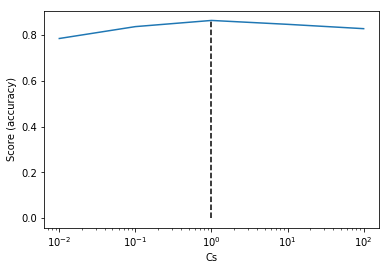

In [22]:
creg=logspace(-2,2,5)
print(creg)
scores=[]

for c in creg:
    logreg=LogisticRegression(solver='liblinear', C=c)
    logreg.fit(X_train, y_train)
    scores.append(logreg.score(X_test, y_test))
    
bestcreg = creg[np.argmax(scores)]
    
print ('\nBest C:', creg[np.argmax(scores)])
print ('\nBest score:', scores[np.argmax(scores)],'\n')

semilogx(creg, scores)
plt.vlines(creg[np.argmax(scores)], 0, scores[np.argmax(scores)], linestyles='dashed')
plt.xlabel('Cs')
plt.ylabel('Score (accuracy)')

Trovo dalla prima ricerca che C=1 è il migliore, raffino la ricerca

In [23]:
creg=linspace(bestcreg-0.5,bestcreg+0.5,5)
print(creg)
scores=[]

for c in creg:
    logreg=LogisticRegression(solver='liblinear', C=c)
    logreg.fit(X_train, y_train)
    scores.append(logreg.score(X_test, y_test))
    
bestcreg = creg[np.argmax(scores)]
    
print ('\nBest C:', creg[np.argmax(scores)])
print ('\nBest score:', scores[np.argmax(scores)],'\n')


[0.5  0.75 1.   1.25 1.5 ]

Best C: 0.75

Best score: 0.865 



C=1.5, raffino

In [24]:
creg=linspace(bestcreg-0.25,bestcreg+0.25,5)
print(creg)
scores=[]

for c in creg:
    logreg=LogisticRegression(solver='liblinear', C=c)
    logreg.fit(X_train, y_train)
    scores.append(logreg.score(X_test, y_test))
    
bestcreg = creg[np.argmax(scores)]
    
print ('\nBest C:', creg[np.argmax(scores)])
print ('\nBest score:', scores[np.argmax(scores)],'\n')


[0.5   0.625 0.75  0.875 1.   ]

Best C: 0.875

Best score: 0.866 



C=1.5, mi sto divertendo e funziona tutto: ne faccio un'altra

In [25]:
creg=linspace(bestcreg-0.125,bestcreg+0.125,5)
print(creg)
scores=[]

for c in creg:
    logreg=LogisticRegression(solver='liblinear', C=c)
    logreg.fit(X_train, y_train)
    scores.append(logreg.score(X_test, y_test))

print('Scores: ', scores)
bestcreg = creg[np.argmax(scores)]

print ('\nBest C:', creg[np.argmax(scores)])
print ('\nBest score:', scores[np.argmax(scores)],'\n')

[0.75   0.8125 0.875  0.9375 1.    ]
Scores:  [0.865, 0.866, 0.866, 0.865, 0.865]

Best C: 0.8125

Best score: 0.866 



ok, basta che sto esagerando

# Multilayer Perceptron - SUBREDDITS

[1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05]

Best Alpha: 0.0001

Best score: 0.869 

Scores:  [0.869, 0.866, 0.867, 0.869, 0.865, 0.737, 0.737, 0.737, 0.737, 0.737]


Text(0, 0.5, 'Score (accuracy)')

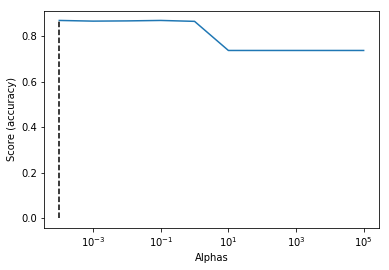

In [26]:
alphas=logspace(-4,5,10)
scores=[]
print(alphas)

for alpha in alphas:
    mlp=MLPClassifier((4,3,2), activation='tanh',solver='adam', early_stopping=True, max_iter=10000,
                                                  learning_rate_init=0.01, random_state=0, alpha=alpha).fit(X_train,y_train)
    scores.append(mlp.score(X_test,y_test))
    
print ('\nBest Alpha:', alphas[np.argmax(scores)])
print ('\nBest score:', scores[np.argmax(scores)],'\n')

bestalpha = alphas[np.argmax(scores)]
print('Scores: ',scores)


semilogx(alphas, scores)
plt.vlines(alphas[np.argmax(scores)], 0, scores[np.argmax(scores)], linestyles='dashed')
plt.xlabel('Alphas')
plt.ylabel('Score (accuracy)')
    

Raffino la ricerca su alpha

[1.00000000e-04 2.78255940e-04 7.74263683e-04 2.15443469e-03
 5.99484250e-03 1.66810054e-02 4.64158883e-02 1.29154967e-01
 3.59381366e-01 1.00000000e+00]

Best Alpha: 0.046415888336127774

Best score: 0.871 

Scores:  [0.869, 0.866, 0.866, 0.866, 0.866, 0.868, 0.871, 0.87, 0.858, 0.865]


Text(0, 0.5, 'Score (accuracy)')

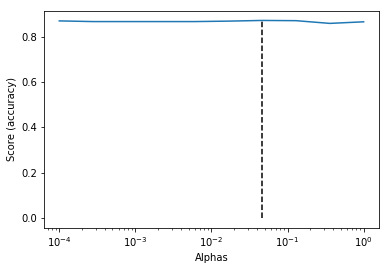

In [27]:
alphas=logspace(-4,0,10)
scores=[]
print(alphas)

for alpha in alphas:
    mlp=MLPClassifier((4,3,2), activation='tanh',solver='adam', early_stopping=True, max_iter=10000,
                                                  learning_rate_init=0.01, random_state=0, alpha=alpha).fit(X_train,y_train)
    scores.append(mlp.score(X_test,y_test))
    
print ('\nBest Alpha:', alphas[np.argmax(scores)])
print ('\nBest score:', scores[np.argmax(scores)],'\n')

bestalpha = alphas[np.argmax(scores)]
print('Scores: ', scores)

semilogx(alphas, scores)
plt.vlines(alphas[np.argmax(scores)], 0, scores[np.argmax(scores)], linestyles='dashed')
plt.xlabel('Alphas')
plt.ylabel('Score (accuracy)')

Provo ancora

In [28]:
a=log10(bestalpha)
a

-1.3333333333333335

[0.01467799 0.01895736 0.02448437 0.03162278 0.04084239 0.05274997
 0.06812921 0.08799225 0.11364637 0.14677993]

Best Alpha: 0.05274997063702617

Best score: 0.871 



Text(0, 0.5, 'Score (accuracy)')

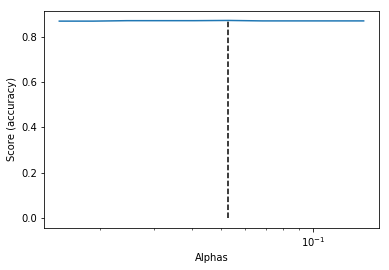

In [29]:

alphas=logspace(a-0.5,a+0.5,10)
scores=[]
print(alphas)

for alpha in alphas:
    mlp=MLPClassifier((4,3,2), activation='tanh',solver='adam', early_stopping=True, max_iter=10000,
                                                  learning_rate_init=0.01, random_state=0, alpha=alpha).fit(X_train,y_train)
    scores.append(mlp.score(X_test,y_test))
    
print ('\nBest Alpha:', alphas[np.argmax(scores)])
print ('\nBest score:', scores[np.argmax(scores)],'\n')

bestalpha = alphas[np.argmax(scores)]

semilogx(alphas, scores)
plt.vlines(alphas[np.argmax(scores)], 0, scores[np.argmax(scores)], linestyles='dashed')
plt.xlabel('Alphas')
plt.ylabel('Score (accuracy)')

Tengo questo

# MULTINOMIAL NAIVE BAYES - SUBREDDITS

[1.e-03 1.e-02 1.e-01 1.e+00 1.e+01]

Best Alfa: 1.0

Best score: 0.871 

Scores:  [0.854, 0.86, 0.865, 0.871, 0.806]


Text(0, 0.5, 'Score (accuracy)')

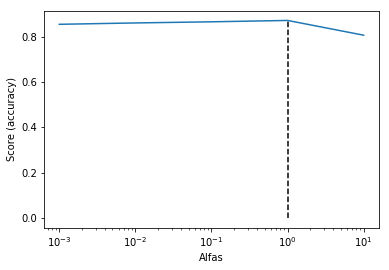

In [30]:
alfas=logspace(-3,1,5)

scores=[]
print(alfas)

for alfa in alfas:
    mnb=MultinomialNB(alpha=alfa).fit(X_train,y_train)
    scores.append(mnb.score(X_test,y_test))
    
print ('\nBest Alfa:', alfas[np.argmax(scores)])
print ('\nBest score:', scores[np.argmax(scores)],'\n')

bestalfa = alfas[np.argmax(scores)]
print('Scores: ', scores)

semilogx(alfas, scores)
plt.vlines(alfas[np.argmax(scores)], 0, scores[np.argmax(scores)], linestyles='dashed')
plt.xlabel('Alfas')
plt.ylabel('Score (accuracy)')
    

Riprovo

[ 0.1         0.16681005  0.27825594  0.46415888  0.77426368  1.29154967
  2.15443469  3.59381366  5.9948425  10.        ]

Best Alfa: 0.774263682681127

Best score: 0.874 

Scores:  [0.865, 0.867, 0.872, 0.872, 0.874, 0.868, 0.862, 0.851, 0.836, 0.806]


Text(0, 0.5, 'Score (accuracy)')

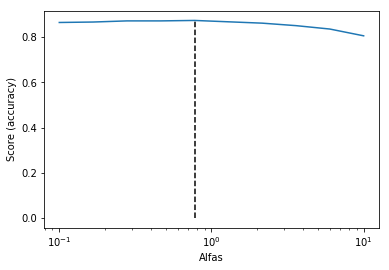

In [31]:
alfas=logspace(-1,1,10)

scores=[]
print(alfas)

for alfa in alfas:
    mnb=MultinomialNB(alpha=alfa).fit(X_train,y_train)
    scores.append(mnb.score(X_test,y_test))
    
print ('\nBest Alfa:', alfas[np.argmax(scores)])
print ('\nBest score:', scores[np.argmax(scores)],'\n')

bestalfa = alfas[np.argmax(scores)]
print('Scores: ', scores)

semilogx(alfas, scores)
plt.vlines(alfas[np.argmax(scores)], 0, scores[np.argmax(scores)], linestyles='dashed')
plt.xlabel('Alfas')
plt.ylabel('Score (accuracy)')

Raffino

[0.1        0.12915497 0.16681005 0.21544347 0.27825594 0.35938137
 0.46415888 0.59948425 0.77426368 1.        ]

Best Alfa: 0.774263682681127

Best score: 0.874 

Scores:  [0.865, 0.867, 0.867, 0.87, 0.872, 0.873, 0.872, 0.872, 0.874, 0.871]


Text(0, 0.5, 'Score (accuracy)')

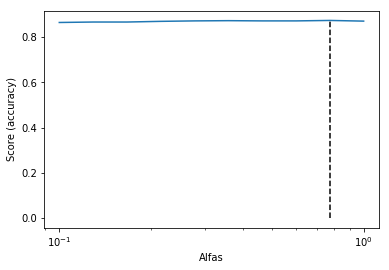

In [32]:
alfas=logspace(-1,0,10)

scores=[]
print(alfas)

for alfa in alfas:
    mnb=MultinomialNB(alpha=alfa).fit(X_train,y_train)
    scores.append(mnb.score(X_test,y_test))
    
print ('\nBest Alfa:', alfas[np.argmax(scores)])
print ('\nBest score:', scores[np.argmax(scores)],'\n')

bestalfa = alfas[np.argmax(scores)]
print('Scores: ', scores)

semilogx(alfas, scores)
plt.vlines(alfas[np.argmax(scores)], 0, scores[np.argmax(scores)], linestyles='dashed')
plt.xlabel('Alfas')
plt.ylabel('Score (accuracy)')

perfetto, così mi piace

## **CALCOLO LE PREDICTED PROBA DEI 3 MODELLI PER I SUBREDDITS**

In [33]:
#Uso tutto il dataset X1 per allenare i migliori modelli trovati

LogReg=LogisticRegression(solver='liblinear', C=bestcreg).fit(X1,y)

MLP=MLPClassifier((4,3,2), activation='tanh',solver='adam', early_stopping=True, max_iter=10000,
                                                  learning_rate_init=0.01, random_state=0, alpha=bestalpha).fit(X1,y)

MNB=MultinomialNB(alpha=bestalfa).fit(X1,y)

#prendo solo la seconda colonna, ovvero la probabilità che gender=1 (donna)
proba1=LogReg.predict_proba(X1)[:,1]
proba2=MLP.predict_proba(X1)[:,1]
proba3=MNB.predict_proba(X1)[:,1]

In [34]:
Proba1=reshape(proba1,(5000,1))
Proba2=reshape(proba2,(5000,1))
Proba3=reshape(proba3,(5000,1))
shape(Proba1)

(5000, 1)

In [35]:
PTOT=hstack([Proba1,Proba2,Proba3])
shape(PTOT)

(5000, 3)

## LOGISTIC REGRESSION ON SUBREDDITS DATA FROM MODELS

In [36]:
X_train, X_test, y_train, y_test = train_test_split(PTOT, y, test_size=.2, random_state = 32)

In [37]:
LRTOT=LogisticRegression(solver='liblinear').fit(X_train,y_train)
score=LRTOT.score(X_test, y_test)
print('Score = ', score)

Score =  0.925


**CREO MATRICE DI DATI DEI SUBREDDITS**

In [38]:
LR=LogisticRegression(solver='liblinear').fit(PTOT,y)
SBRDDTS=reshape(LR.predict_proba(PTOT)[:,1],(5000,1))
shape(SBRDDTS)

(5000, 1)

# Model Selection - TFIDF

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=.2, random_state = 32)


In [40]:
best_score=.0
best_name=' '

for name in models:
    clf = models[name]
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    if score>best_score:
        best_score=score
        best_name=name
    print(name, score)
    
print('\nBest model is ', best_name, 'with a score = ', best_score)

Knn 5 0.752
Gaussian Naive Bayes 0.734
Multinomial Naive Bayes 0.795
Logistic Regression 0.828
Classification Tree 0.775
Random Forest 0.748
Multilayer Perceptron 0.821

Best model is  Logistic Regression with a score =  0.828


# Logistic Regression - TFIDF

[1.e-02 1.e-01 1.e+00 1.e+01 1.e+02]

Best C: 10.0

Best score: 0.829 



Text(0, 0.5, 'Score (accuracy)')

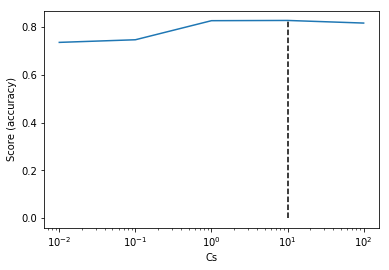

In [41]:
creg=logspace(-2,2,5)
print(creg)
scores=[]

for c in creg:
    logreg=LogisticRegression(solver='liblinear', C=c)
    logreg.fit(X_train, y_train)
    scores.append(logreg.score(X_test, y_test))
    
bestcreg = creg[np.argmax(scores)]
    
print ('\nBest C:', creg[np.argmax(scores)])
print ('\nBest score:', scores[np.argmax(scores)],'\n')

semilogx(creg, scores)
plt.vlines(creg[np.argmax(scores)], 0, scores[np.argmax(scores)], linestyles='dashed')
plt.xlabel('Cs')
plt.ylabel('Score (accuracy)')

Raffino

In [42]:
a=log10(bestcreg)
print(a)

creg=logspace(a-1,a+1,5)
print(creg)
scores=[]

for c in creg:
    logreg=LogisticRegression(solver='liblinear', C=c)
    logreg.fit(X_train, y_train)
    scores.append(logreg.score(X_test, y_test))
    
bestcreg = creg[np.argmax(scores)]
    
print ('\nBest C:', creg[np.argmax(scores)])
print ('\nBest score:', scores[np.argmax(scores)],'\n')

1.0
[  1.           3.16227766  10.          31.6227766  100.        ]

Best C: 3.1622776601683795

Best score: 0.829 



raffino

In [43]:
creg=logspace(0,1,10)
print(creg)
scores=[]

for c in creg:
    logreg=LogisticRegression(solver='liblinear', C=c)
    logreg.fit(X_train, y_train)
    scores.append(logreg.score(X_test, y_test))
    
bestcreg = creg[np.argmax(scores)]
    
print ('\nBest C:', creg[np.argmax(scores)])
print ('\nBest score:', scores[np.argmax(scores)],'\n')

[ 1.          1.29154967  1.66810054  2.15443469  2.7825594   3.59381366
  4.64158883  5.9948425   7.74263683 10.        ]

Best C: 5.994842503189409

Best score: 0.835 



# MLP - TFIDF

Cerco alpha regolarizzazione migliore

[1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05]

Best Alpha: 0.1

Best score: 0.827 

Scores:  [0.821, 0.821, 0.82, 0.827, 0.737, 0.737, 0.737, 0.737, 0.737, 0.737]


Text(0, 0.5, 'Score (accuracy)')

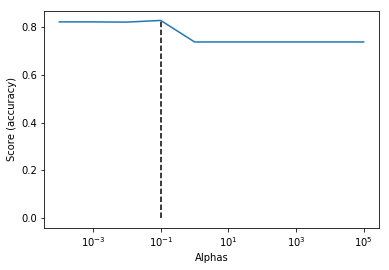

In [44]:
alphas=logspace(-4,5,10)
scores=[]
print(alphas)

for alpha in alphas:
    mlp=MLPClassifier((4,3,2), activation='tanh',solver='adam', early_stopping=True, max_iter=10000,
                                                  learning_rate_init=0.01, random_state=0, alpha=alpha).fit(X_train,y_train)
    scores.append(mlp.score(X_test,y_test))
    
print ('\nBest Alpha:', alphas[np.argmax(scores)])
print ('\nBest score:', scores[np.argmax(scores)],'\n')

bestalpha = alphas[np.argmax(scores)]
print('Scores: ',scores)


semilogx(alphas, scores)
plt.vlines(alphas[np.argmax(scores)], 0, scores[np.argmax(scores)], linestyles='dashed')
plt.xlabel('Alphas')
plt.ylabel('Score (accuracy)')

Raffino

[0.01       0.01668101 0.02782559 0.04641589 0.07742637 0.12915497
 0.21544347 0.35938137 0.59948425 1.        ]

Best Alpha: 0.0774263682681127

Best score: 0.833 

Scores:  [0.82, 0.82, 0.822, 0.824, 0.833, 0.822, 0.833, 0.737, 0.737, 0.737]


Text(0, 0.5, 'Score (accuracy)')

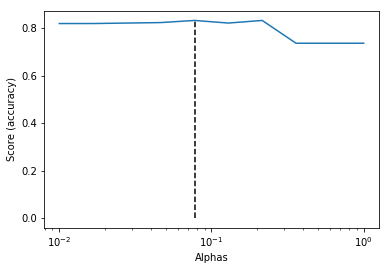

In [45]:
a=log10(bestalpha)

alphas=logspace(a-1,a+1,10)
scores=[]
print(alphas)

for alpha in alphas:
    mlp=MLPClassifier((4,3,2), activation='tanh',solver='adam', early_stopping=True, max_iter=10000,
                                                  learning_rate_init=0.01, random_state=0, alpha=alpha).fit(X_train,y_train)
    scores.append(mlp.score(X_test,y_test))
    
print ('\nBest Alpha:', alphas[np.argmax(scores)])
print ('\nBest score:', scores[np.argmax(scores)],'\n')

bestalpha = alphas[np.argmax(scores)]
print('Scores: ', scores)

semilogx(alphas, scores)
plt.vlines(alphas[np.argmax(scores)], 0, scores[np.argmax(scores)], linestyles='dashed')
plt.xlabel('Alphas')
plt.ylabel('Score (accuracy)')

## **CALCOLO LE PREDICTED PROBA DEI 3 MODELLI PER TFIDF**

In [46]:
#Uso tutto il dataset X2 per allenare i migliori modelli trovati

LogReg=LogisticRegression(solver='liblinear', C=bestcreg).fit(X2,y)

MLP=MLPClassifier((4,3,2), activation='tanh',solver='adam', early_stopping=True, max_iter=10000,
                                                  learning_rate_init=0.01, random_state=0, alpha=bestalpha).fit(X2,y)

#prendo solo la seconda colonna, ovvero la probabilità che gender=1 (donna)
proba1=LogReg.predict_proba(X2)[:,1]
proba2=MLP.predict_proba(X2)[:,1]

In [47]:
Proba1=reshape(proba1,(5000,1))
Proba2=reshape(proba2,(5000,1))
shape(Proba1)

(5000, 1)

In [48]:
PTOT=hstack([Proba1,Proba2])
shape(PTOT)

(5000, 2)

## LOGISTIC REGRESSION ON TFIDF DATA FROM MODELS

In [49]:
X_train, X_test, y_train, y_test = train_test_split(PTOT, y, test_size=.2, random_state = 32)

In [50]:
LRTOT=LogisticRegression(solver='liblinear').fit(X_train,y_train)
score=LRTOT.score(X_test, y_test)
print('Score = ', score)

Score =  0.974


**CREO MATRICE DATI DEI TFIDF**

In [51]:
LR=LogisticRegression(solver='liblinear').fit(PTOT,y)
TFIDF=reshape(LR.predict_proba(PTOT)[:,1],(5000,1))
shape(TFIDF)

(5000, 1)

# Model Selection - EVERYFEATURE

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=.2, random_state = 32)

In [53]:
best_score=.0
best_name=' '

for name in models:
    clf = models[name]
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    if score>best_score:
        best_score=score
        best_name=name
    print(name, score)
    
print('\nBest model is ', best_name, 'with a score = ', best_score)

Knn 5 0.76
Gaussian Naive Bayes 0.683
Multinomial Naive Bayes 0.878
Logistic Regression 0.878
Classification Tree 0.798
Random Forest 0.747
Multilayer Perceptron 0.881

Best model is  Multilayer Perceptron with a score =  0.881


# Logistic Regression - EVERYFEATURE

[1.e-02 1.e-01 1.e+00 1.e+01 1.e+02]

Best C: 1.0

Best score: 0.878 



Text(0, 0.5, 'Score (accuracy)')

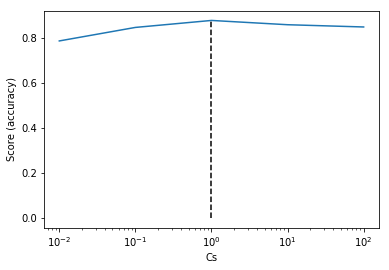

In [54]:
creg=logspace(-2,2,5)
print(creg)
scores=[]

for c in creg:
    logreg=LogisticRegression(solver='liblinear', C=c)
    logreg.fit(X_train, y_train)
    scores.append(logreg.score(X_test, y_test))
    
bestcreg = creg[np.argmax(scores)]
    
print ('\nBest C:', creg[np.argmax(scores)])
print ('\nBest score:', scores[np.argmax(scores)],'\n')

semilogx(creg, scores)
plt.vlines(creg[np.argmax(scores)], 0, scores[np.argmax(scores)], linestyles='dashed')
plt.xlabel('Cs')
plt.ylabel('Score (accuracy)')

Raffino

In [55]:
a=log10(bestcreg)
print(a)

creg=logspace(a-1,a+1,5)
print(creg)
scores=[]

for c in creg:
    logreg=LogisticRegression(solver='liblinear', C=c)
    logreg.fit(X_train, y_train)
    scores.append(logreg.score(X_test, y_test))
    
bestcreg = creg[np.argmax(scores)]
    
print ('\nBest C:', creg[np.argmax(scores)])
print ('\nBest score:', scores[np.argmax(scores)],'\n')

0.0
[ 0.1         0.31622777  1.          3.16227766 10.        ]

Best C: 1.0

Best score: 0.878 



Raffino

In [56]:
creg=linspace(0.316,3.16,10)
print(creg)
scores=[]

for c in creg:
    logreg=LogisticRegression(solver='liblinear', C=c)
    logreg.fit(X_train, y_train)
    scores.append(logreg.score(X_test, y_test))
    
bestcreg = creg[np.argmax(scores)]
    
print ('\nBest C:', creg[np.argmax(scores)])
print ('\nBest score:', scores[np.argmax(scores)],'\n')

[0.316 0.632 0.948 1.264 1.58  1.896 2.212 2.528 2.844 3.16 ]

Best C: 0.6320000000000001

Best score: 0.88 



# MLP - EVERYFEATURE

Cerco miglior alpha regolarizzazione

[1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05]

Best Alpha: 0.0001

Best score: 0.881 

Scores:  [0.881, 0.88, 0.881, 0.878, 0.87, 0.737, 0.737, 0.737, 0.737, 0.737]


Text(0, 0.5, 'Score (accuracy)')

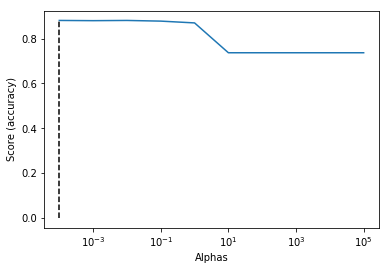

In [57]:
alphas=logspace(-4,5,10)
scores=[]
print(alphas)

for alpha in alphas:
    mlp=MLPClassifier((4,3,2), activation='tanh',solver='adam', early_stopping=True, max_iter=10000,
                                                  learning_rate_init=0.01, random_state=0, alpha=alpha).fit(X_train,y_train)
    scores.append(mlp.score(X_test,y_test))
    
print ('\nBest Alpha:', alphas[np.argmax(scores)])
print ('\nBest score:', scores[np.argmax(scores)],'\n')

bestalpha = alphas[np.argmax(scores)]
print('Scores: ',scores)


semilogx(alphas, scores)
plt.vlines(alphas[np.argmax(scores)], 0, scores[np.argmax(scores)], linestyles='dashed')
plt.xlabel('Alphas')
plt.ylabel('Score (accuracy)')

Raffino

-2.0
[0.001      0.0016681  0.00278256 0.00464159 0.00774264 0.0129155
 0.02154435 0.03593814 0.05994843 0.1       ]

Best Alpha: 0.021544346900318832

Best score: 0.884 

Scores:  [0.88, 0.881, 0.881, 0.875, 0.875, 0.883, 0.884, 0.872, 0.881, 0.878]


Text(0, 0.5, 'Score (accuracy)')

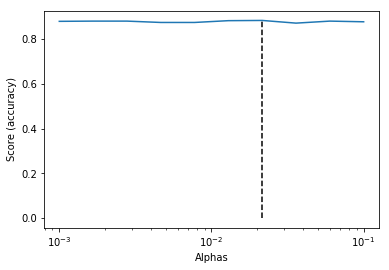

In [58]:
bestalpha=1.e-2
a=log10(bestalpha)
print(a)

alphas=logspace(a-1,a+1,10)
scores=[]
print(alphas)

for alpha in alphas:
    mlp=MLPClassifier((4,3,2), activation='tanh',solver='adam', early_stopping=True, max_iter=10000,
                                                  learning_rate_init=0.01, random_state=0, alpha=alpha).fit(X_train,y_train)
    scores.append(mlp.score(X_test,y_test))
    
print ('\nBest Alpha:', alphas[np.argmax(scores)])
print ('\nBest score:', scores[np.argmax(scores)],'\n')

bestalpha = alphas[np.argmax(scores)]
print('Scores: ', scores)

semilogx(alphas, scores)
plt.vlines(alphas[np.argmax(scores)], 0, scores[np.argmax(scores)], linestyles='dashed')
plt.xlabel('Alphas')
plt.ylabel('Score (accuracy)')

# MultinomialNaiveBayes - EVERYFEATURE

[1.e-03 1.e-02 1.e-01 1.e+00 1.e+01]

Best Alfa: 1.0

Best score: 0.878 

Scores:  [0.86, 0.868, 0.876, 0.878, 0.774]


Text(0, 0.5, 'Score (accuracy)')

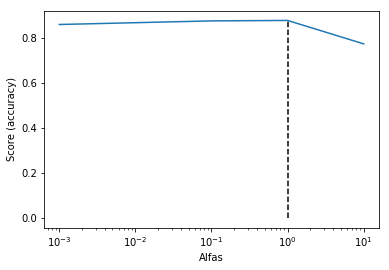

In [59]:
alfas=logspace(-3,1,5)

scores=[]
print(alfas)

for alfa in alfas:
    mnb=MultinomialNB(alpha=alfa).fit(X_train,y_train)
    scores.append(mnb.score(X_test,y_test))
    
print ('\nBest Alfa:', alfas[np.argmax(scores)])
print ('\nBest score:', scores[np.argmax(scores)],'\n')

bestalfa = alfas[np.argmax(scores)]
print('Scores: ', scores)

semilogx(alfas, scores)
plt.vlines(alfas[np.argmax(scores)], 0, scores[np.argmax(scores)], linestyles='dashed')
plt.xlabel('Alfas')
plt.ylabel('Score (accuracy)')

Raffino

[ 0.1         0.16681005  0.27825594  0.46415888  0.77426368  1.29154967
  2.15443469  3.59381366  5.9948425  10.        ]

Best Alfa: 0.46415888336127786

Best score: 0.882 

Scores:  [0.876, 0.877, 0.879, 0.882, 0.878, 0.878, 0.868, 0.844, 0.805, 0.774]


Text(0, 0.5, 'Score (accuracy)')

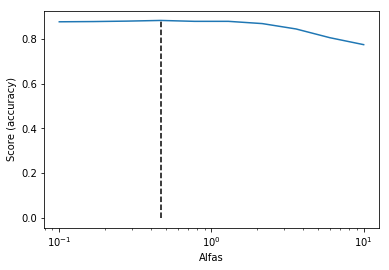

In [60]:
alfas=logspace(-1,1,10)

scores=[]
print(alfas)

for alfa in alfas:
    mnb=MultinomialNB(alpha=alfa).fit(X_train,y_train)
    scores.append(mnb.score(X_test,y_test))
    
print ('\nBest Alfa:', alfas[np.argmax(scores)])
print ('\nBest score:', scores[np.argmax(scores)],'\n')

bestalfa = alfas[np.argmax(scores)]
print('Scores: ', scores)

semilogx(alfas, scores)
plt.vlines(alfas[np.argmax(scores)], 0, scores[np.argmax(scores)], linestyles='dashed')
plt.xlabel('Alfas')
plt.ylabel('Score (accuracy)')

Raffino

[0.1        0.12915497 0.16681005 0.21544347 0.27825594 0.35938137
 0.46415888 0.59948425 0.77426368 1.        ]

Best Alfa: 0.46415888336127786

Best score: 0.882 

Scores:  [0.876, 0.876, 0.877, 0.879, 0.879, 0.88, 0.882, 0.881, 0.878, 0.878]


Text(0, 0.5, 'Score (accuracy)')

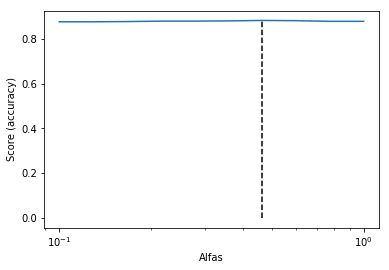

In [61]:
alfas=logspace(-1,0,10)

scores=[]
print(alfas)

for alfa in alfas:
    mnb=MultinomialNB(alpha=alfa).fit(X_train,y_train)
    scores.append(mnb.score(X_test,y_test))
    
print ('\nBest Alfa:', alfas[np.argmax(scores)])
print ('\nBest score:', scores[np.argmax(scores)],'\n')

bestalfa = alfas[np.argmax(scores)]
print('Scores: ', scores)

semilogx(alfas, scores)
plt.vlines(alfas[np.argmax(scores)], 0, scores[np.argmax(scores)], linestyles='dashed')
plt.xlabel('Alfas')
plt.ylabel('Score (accuracy)')

## **CALCOLO LE PREDICTED PROBA DEI 3 MODELLI PER EVERYFEATURE**

In [62]:
#Uso tutto il dataset X3 per allenare i migliori modelli trovati

LogReg=LogisticRegression(solver='liblinear', C=bestcreg).fit(X3,y)

MLP=MLPClassifier((4,3,2), activation='tanh',solver='adam', early_stopping=True, max_iter=10000,
                                                  learning_rate_init=0.01, random_state=0, alpha=bestalpha).fit(X3,y)

MNB=MultinomialNB(alpha=bestalfa).fit(X3,y)

#prendo solo la seconda colonna, ovvero la probabilità che gender=1 (donna)
proba1=LogReg.predict_proba(X3)[:,1]
proba2=MLP.predict_proba(X3)[:,1]
proba3=MNB.predict_proba(X3)[:,1]

In [63]:
Proba1=reshape(proba1,(5000,1))
Proba2=reshape(proba2,(5000,1))
Proba3=reshape(proba3,(5000,1))
shape(Proba1)

(5000, 1)

In [64]:
PTOT=hstack([Proba1,Proba2,Proba3])
shape(PTOT)

(5000, 3)

## LOGISTIC REGRESSION ON EVERYFEATURE DATA FROM MODELS

In [65]:
X_train, X_test, y_train, y_test = train_test_split(PTOT, y, test_size=.2, random_state = 32)

In [66]:
LRTOT=LogisticRegression(solver='liblinear').fit(X_train,y_train)
score=LRTOT.score(X_test, y_test)
print('Score = ', score)

Score =  0.962


**CREO MATRICE DATI DI EVERYFEATURE**

In [67]:
LR=LogisticRegression(solver='liblinear').fit(PTOT,y)
EVRYFTR=reshape(LR.predict_proba(PTOT)[:,1],(5000,1))
shape(EVRYFTR)

(5000, 1)

# FASE FINALE: LOGISTIC REGRESSION ON DATA FROM EXPERIMENTS

Creo la matrice di dati totale con le features ottenute dai 3 data sets (subreddits, tfidf, everyfeature)

In [68]:
MATRICIONE=hstack([SBRDDTS, TFIDF, EVRYFTR])
shape(MATRICIONE)

(5000, 3)

La do in pasto a una logistic regression e valuto lo score

In [69]:
X_train, X_test, y_train, y_test = train_test_split(MATRICIONE, y, test_size=.2, random_state = 32)

In [70]:
LRFinale=LogisticRegression(solver='liblinear').fit(X_train, y_train)
rate=LRFinale.score(X_test, y_test)
print('FINAL PREDICTED SCORE = ',rate)

FINAL PREDICTED SCORE =  0.982


# Prepare the solution

## Load Data

In [3]:
test_data = pd.read_csv("/home/gdeandrea/Scrivania/UNI/Data Mining/ESAME2020/Kaggle data/test_data.csv", encoding="utf8")

In [24]:
test_data.head()

,author,subreddit,created_utc,body
0,ejchristian86,TwoXChromosomes,1.388534e+09,I hadn't ever heard of them before joining thi...
1,ZenDragon,gaming,1.388534e+09,"At 7680 by 4320 with 64x AA, right?"
2,savoytruffle,AskReddit,1.388534e+09,bite me
3,hentercenter,stlouisblues,1.388534e+09,Damn that was a good penalty :(
4,rick-o-suave,army,1.388534e+09,I swore into DEP on 6-OCT and I left 5-NOV und...


## Features Extraction

In [25]:
features_dict = {}

for author, group in test_data.groupby('author'):
    features_dict[author] = extract_features(group)

In [27]:
X_test = sparse.vstack([features_dict[author] for author in test_data.author.unique()])

In [28]:
Xtest=X_test.toarray()

## Text Extraction

In [29]:
test_data.body=test_data['body'].apply(str)
#text.CountVectorizer()

In [31]:
test_data.author.unique().shape

(15000,)

In [32]:
text_dict_test = {}

for author, group in test_data.groupby('author'):
    text_dict_test[author] = extract_text(group)

In [33]:
author_text_test = [text_dict_test[author] for author in test_data.author]
author_text_test[10]

'Whenever I look at these, I always think that in the best fits, people are way more out there with color combinations than I am.  I always get nervous about using warmer colors like reds and yellows, and almost exclusively stick to blues, purples, greys, and greens.  A lot of these fits make me think I should branch out more, but it also might be a personal style thing. I think there\'s some great fits in there, but it\'s also reinforcing my opinion that pea coats are kinda overdone right now. I live in an apartment, and I personally hang my shirts on the curtain rod in the shower overnight.  Works fine.  Dunno what to do if you\'re in a dorm without a private bathroom, though. Drive to Freeport.  It\'s like a pilgrimage. Hm, dug into this a little because it seemed weird, what with that logo being the same as camel cigarettes, and I thought it might be just a random "asian countries like things that look vaguely American" thing that you see when you travel in asia all the time.  But 

In [ ]:
C_test = cv.transform(author_text_test)
tfidfbis = text.TfidfTransformer().transform(C_test)

In [ ]:
print('SHAPE&TYPE TFIDF:', shape(tfidfbis),' || ', type(tfidfbis))
print('SHAPE&TYPE X:', shape(Xtest),' || ', type(Xtest))

**Preprocesso i dati per renderli mangiabili da LRFinale

In [ ]:
y_pred = model.predict_proba(X_test)[:,1]

In [ ]:
solution = pd.DataFrame({"author":test_data.author.unique(), "gender":y_pred})
solution.head()

In [ ]:
solution.to_csv("solution.csv", index=False)

In [ ]:
%%sh
head solution.csv